In [27]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import zipfile
from sklearn.preprocessing import RobustScaler

In [28]:
data0D = pd.read_csv("./data/0D.csv")
data0E = pd.read_csv("./data/0E.csv")
data1D = pd.read_csv("./data/1D.csv")
data1E = pd.read_csv("./data/1E.csv")
data2D = pd.read_csv("./data/2D.csv")
data2E = pd.read_csv("./data/2E.csv")
data3D = pd.read_csv("./data/3D.csv")
data3E = pd.read_csv("./data/3E.csv")
data4D = pd.read_csv("./data/4D.csv")
data4E = pd.read_csv("./data/4E.csv")





In [29]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 'Vibration_1'
samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data0D[sensor], "no_unbalance")
X1,y1 = get_features(data1D[sensor], "unbalance")
X2,y2 = get_features(data2D[sensor], "unbalance")
X3,y3 = get_features(data3D[sensor], "unbalance")
X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X0_val, y0_val = get_features(data0E[sensor], "no_unbalance")
X1_val, y1_val = get_features(data1E[sensor], "unbalance")
X2_val, y2_val = get_features(data2E[sensor], "unbalance")
X3_val, y3_val = get_features(data3E[sensor], "unbalance")
X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

In [30]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(32226, 4096) (32226,) (8420, 4096) (8420,)


In [31]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)

In [32]:
print(X_train.shape, y_train.shape , X_test.shape, y_test.shape)

(29003, 4096) (29003,) (3223, 4096) (3223,)


In [33]:
X_fft = np.abs(np.fft.rfft(X, axis=1))[:,:int(window/2)]
X_train_fft = np.abs(np.fft.rfft(X_train, axis=1))[:,:int(window/2)]
X_test_fft = np.abs(np.fft.rfft(X_test, axis=1))[:,:int(window/2)]
X_val_fft = np.abs(np.fft.rfft(X_val, axis=1))[:,:int(window/2)]

X_fft[:,0]=0
X_train_fft[:,0]=0
X_test_fft[:,0]=0
X_val_fft[:,0]=0

In [34]:
print(X_train_fft.shape, X_test_fft.shape, X_val_fft.shape)

(29003, 2048) (3223, 2048) (8420, 2048)


# Scaling

In [35]:
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train_fft)

X_fft_sc = scaler.transform(X_fft)
X_train_fft_sc = scaler.transform(X_train_fft)
X_test_fft_sc = scaler.transform(X_test_fft)
X_val_fft_sc = scaler.transform(X_val_fft)

## Evaluation of Model performance depending on number of layers

Five different fully connected neural networks (FCN) with zero (equivalent to logistic regression) to
four hidden layers are trained using the training data.

In [36]:
X_val_fft_1 = X_val_fft_sc[:len(y0_val),:]
y_val_1 = y_val[:len(y0_val)]
X_val_fft_2 = X_val_fft_sc[len(y0_val):len(y0_val)+len(y1_val),:]
y_val_2 = y_val[len(y0_val):len(y0_val)+len(y1_val)]
X_val_fft_3 = X_val_fft_sc[len(y0_val)+len(y1_val):len(y0_val)+
                           len(y1_val)+len(y2_val),:]
y_val_3 = y_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val)]
X_val_fft_4 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                           len(y1_val)+len(y2_val)+len(y3_val),:]
y_val_4 = y_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+len(y1_val)+
                len(y2_val)+len(y3_val)]
X_val_fft_5 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
                           len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:]
y_val_5 = y_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+len(y1_val)+
                len(y2_val)+len(y3_val)+len(y4_val)]

In [40]:
use_reference_models = False
model_path = './models'

In [41]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

if not use_reference_models:
    
    weight_for_0 = len(y)/(2*len(y[y==0]))
    weight_for_1 = len(y)/(2*len(y[y==1]))
    class_weight = {0: weight_for_0, 1: weight_for_1}
    

    epochs = 100

    for i in range(5):
        X_in = Input(shape=(X_train_fft.shape[1],), name="cam_layer")
        x = X_in
        for j in range(i):
            x = Dense(units = 1024, activation="linear")(x)
            x = LeakyReLU(alpha=0.05)(x)
        X_out = Dense(units = 1, activation = 'sigmoid')(x)
        model_i = Model(X_in, X_out)


        best_model_filepath = f"{model_path}/fft_fcn_{i}_layers.h5"
        checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                     verbose=1, save_best_only=True, mode='min')

        model_i.compile(optimizer = Adam(lr=0.0005), loss = 'binary_crossentropy', 
                        metrics = ['accuracy'])
        model_i.summary()

        model_i.fit(X_train_fft_sc, y_train, epochs = 100, batch_size = 128,
                       validation_data=(X_test_fft_sc, y_test), callbacks=[checkpoint], 
                    class_weight=class_weight)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cam_layer (InputLayer)      [(None, 2048)]            0         
                                                                 
 dense_23 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 2049 (8.00 KB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
199/227 [=========================>....] - ETA: 0s - loss: 0.5981 - accuracy: 0.7068
Epoch 1: val_loss improved from inf to 0.40947, saving model to ./models\fft_fcn_0_layers.h5
227/227 [==============================] - 1s 3ms/step - loss: 0.5631 - accuracy: 0.7165 - val_loss: 0.4095 - val_accuracy: 0.7940
Epoch 2/100
 27/227 [==>...........................] - ETA: 0s - loss: 0.3060 - accuracy: 0.7966

c:\Users\Dell\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/227 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8171
Epoch 2: val_loss did not improve from 0.40947
227/227 [==============================] - 1s 2ms/step - loss: 0.3403 - accuracy: 0.8171 - val_loss: 0.8001 - val_accuracy: 0.8197
Epoch 3/100
194/227 [========================>.....] - ETA: 0s - loss: 0.2746 - accuracy: 0.8490
Epoch 3: val_loss improved from 0.40947 to 0.29511, saving model to ./models\fft_fcn_0_layers.h5
227/227 [==============================] - 0s 2ms/step - loss: 0.2754 - accuracy: 0.8522 - val_loss: 0.2951 - val_accuracy: 0.8650
Epoch 4/100
199/227 [=========================>....] - ETA: 0s - loss: 0.3268 - accuracy: 0.8647
Epoch 4: val_loss improved from 0.29511 to 0.24492, saving model to ./models\fft_fcn_0_layers.h5
227/227 [==============================] - 0s 2ms/step - loss: 0.3118 - accuracy: 0.8675 - val_loss: 0.2449 - val_accuracy: 0.8747
Epoch 5/100
224/227 [============================>.] - ETA: 0s - loss: 0.3004 - accurac

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cam_layer (InputLayer)      [(None, 2048)]            0         
                                                                 
 dense_24 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 2099201 (8.01 MB)
Trainable params: 2099201 (8.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
226/227 [============================>.] - ETA: 0s - loss: 0.5649 - accuracy: 0.9294
Epoch 1: val_loss improved from inf to 0.48403, saving 

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cam_layer (InputLayer)      [(None, 2048)]            0         
                                                                 
 dense_26 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_28 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 3148801 (12.01 MB)
Trainable params: 3148801

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cam_layer (InputLayer)      [(None, 2048)]            0         
                                                                 
 dense_29 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_30 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_31 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 1024)              0  

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cam_layer (InputLayer)      [(None, 2048)]            0         
                                                                 
 dense_33 (Dense)            (None, 1024)              2098176   
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_34 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 1024)              0  

In [42]:
from tensorflow.keras.models import load_model

model_loss = []
model_acc = []
model_accs_per_class = []

for i in range(5):
    best_model_filepath = f"{model_path}/fft_fcn_{i}_layers.h5"
    model_i = load_model(best_model_filepath)
    train_acc_ges = model_i.evaluate(X_train_fft_sc, y_train)
    val_acc_ges = model_i.evaluate(X_val_fft_sc, y_val)
    
    val_acc_1 = model_i.evaluate(X_val_fft_1, y_val_1)
    val_acc_2 = model_i.evaluate(X_val_fft_2, y_val_2)
    val_acc_3 = model_i.evaluate(X_val_fft_3, y_val_3)
    val_acc_4 = model_i.evaluate(X_val_fft_4, y_val_4)
    val_acc_5 = model_i.evaluate(X_val_fft_5, y_val_5)
    
    model_acc.append([train_acc_ges[1], val_acc_ges[1]])
    model_loss.append([train_acc_ges[0], val_acc_ges[0]])
    model_accs_per_class.append([val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5])

53/53 [==============================] - 1s 11ms/step - loss: 0.0012 - accuracy: 1.0000


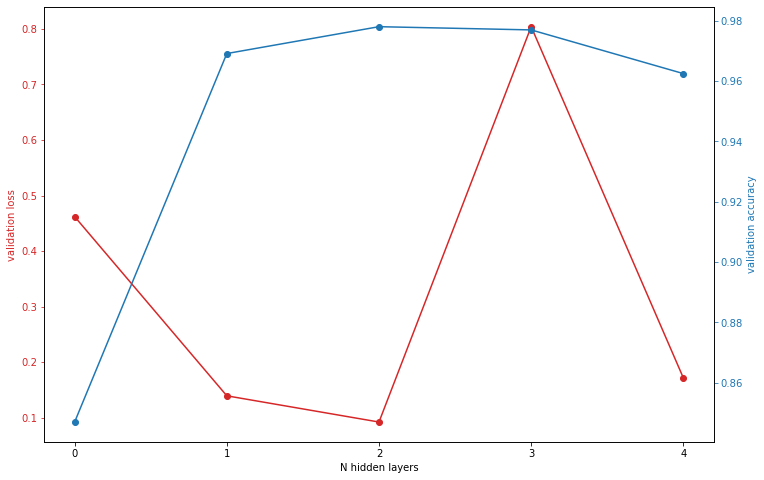

In [43]:
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111)
ax1.plot(np.array(model_loss)[:,1], color="tab:red", marker="o")
ax1.tick_params('y', colors='tab:red')
ax1.set_ylabel(ylabel = "validation loss", color="tab:red")
ax1.set_xticks([0,1,2,3,4])
ax1.set_xlabel("N hidden layers")
ax2 = ax1.twinx()
ax2.plot(np.array(model_acc)[:,1], color="tab:blue", marker="o")
ax2.tick_params('y', colors='tab:blue')
ax2.set_ylabel(ylabel = "validation accuracy", color="tab:blue")
plt.show()

In [44]:
np.array(model_accs_per_class)[0,:,1]

array([0.98275864, 0.57295376, 0.97917908, 0.71318293, 0.9869591 ])

In [45]:
from tensorflow.keras.models import load_model
model0 = load_model(f"{model_path}/fft_fcn_0_layers.h5")
model1 = load_model(f"{model_path}/fft_fcn_1_layers.h5")
model2 = load_model(f"{model_path}/fft_fcn_2_layers.h5")
model3 = load_model(f"{model_path}/fft_fcn_3_layers.h5")
model4 = load_model(f"{model_path}/fft_fcn_4_layers.h5")

In [46]:
accuracies_per_class = []
for i in range(5):
    filepath_i = f"{model_path}/fft_fcn_{i}_layers.h5"
    model_i = load_model(filepath_i)
    
    val_acc_1 = model_i.evaluate(X_val_fft_1, y_val_1)
    val_acc_2 = model_i.evaluate(X_val_fft_2, y_val_2)
    val_acc_3 = model_i.evaluate(X_val_fft_3, y_val_3)
    val_acc_4 = model_i.evaluate(X_val_fft_4, y_val_4)
    val_acc_5 = model_i.evaluate(X_val_fft_5, y_val_5)
    accuracies_per_class.append([val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5])

53/53 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 1.0000


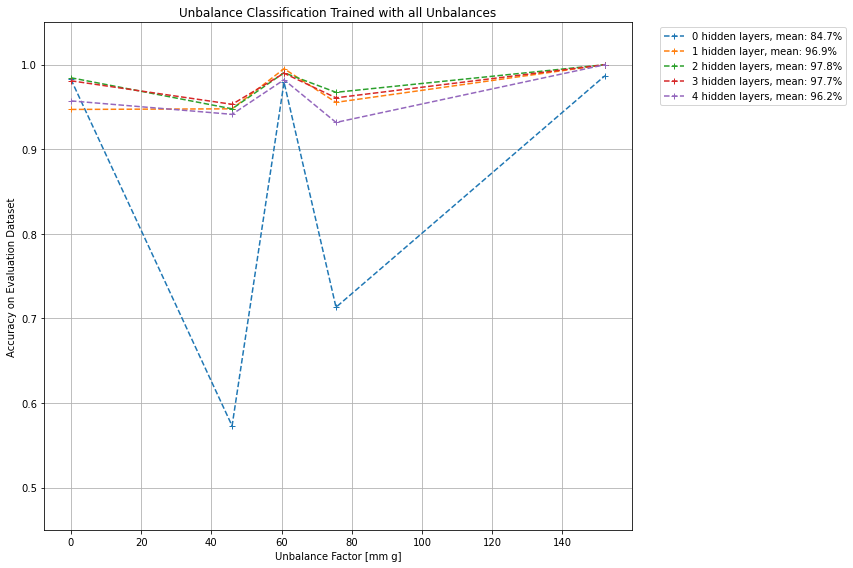

In [47]:
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[0,:,1], label=f"0 hidden layers, mean: {100.0*np.mean(np.array(accuracies_per_class)[0,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[1,:,1], label=f"1 hidden layer, mean: {100.0*np.mean(np.array(accuracies_per_class)[1,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[2,:,1], label=f"2 hidden layers, mean: {100.0*np.mean(np.array(accuracies_per_class)[2,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[3,:,1], label=f"3 hidden layers, mean: {100.0*np.mean(np.array(accuracies_per_class)[3,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[4,:,1], label=f"4 hidden layers, mean: {100.0*np.mean(np.array(accuracies_per_class)[4,:,1]):.1f}%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0.45, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
from scipy.stats import mode

def v2rpm(v):
    return 212*v + 209

# 3s ramp up
fade_in = np.arange(0.0, 4.0, 4.0/(3*4096))
# complete voltage sweep
measurement_circle = np.repeat(np.arange(4.0, 8.2, 0.1), 4096*20.0)
# measurement: start-up + 2 voltage sweeps
measurement = np.concatenate([fade_in, np.tile(measurement_circle,3)]) 
# select the data as actually used
measurement1 = measurement[50000:]
measurement1 = measurement1[:int(len(measurement1)/4096)*4096].reshape(-1,4096)
voltages_measurement = mode(measurement1, axis=1)[0]
voltages_used = np.concatenate([voltages_measurement[:len(X_val_fft_1)],
                                voltages_measurement[:len(X_val_fft_2)],
                                voltages_measurement[:len(X_val_fft_3)],
                                voltages_measurement[:len(X_val_fft_4)],
                                voltages_measurement[:len(X_val_fft_5)]])
rpms_used = v2rpm(voltages_used)

In [49]:
rpm_borders = np.arange(1050, 1975, 25)
errors_per_rpm_range0 = []
errors_per_rpm_range1 = []
errors_per_rpm_range2 = []
errors_per_rpm_range3 = []
errors_per_rpm_range4 = []
for i in range(len(rpm_borders)-1):
    eval_inds = np.where((rpms_used>rpm_borders[i])&(rpms_used<rpm_borders[i+1]))[0]
    errors_per_rpm_range0.append(
        1-np.mean(np.abs(np.int32(model0.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range1.append(
        1-np.mean(np.abs(np.int32(model1.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range2.append(
        1-np.mean(np.abs(np.int32(model2.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range3.append(
        1-np.mean(np.abs(np.int32(model3.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range4.append(
        1-np.mean(np.abs(np.int32(model4.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))

7/7 [==============================] - 0s 8ms/step


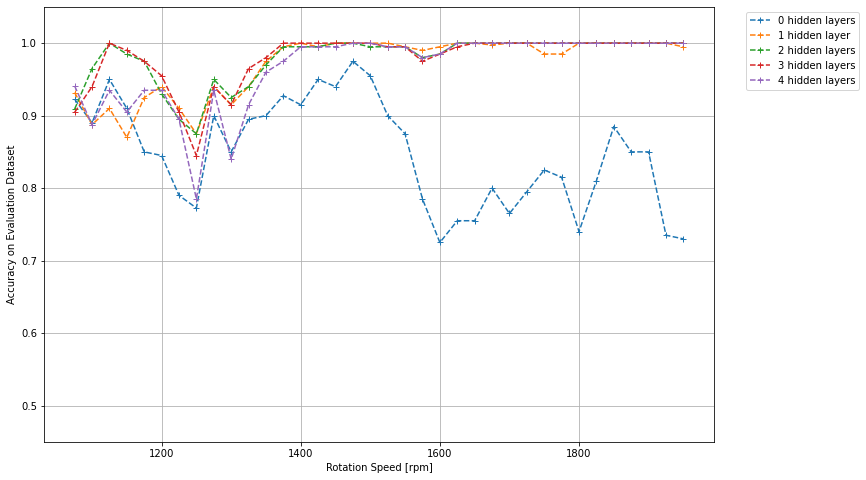

In [50]:
fig=plt.figure(figsize=(12,8))
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range0, marker="+", ls="--", label="0 hidden layers")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, marker="+", ls="--", label="1 hidden layer")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, marker="+", ls="--", label="2 hidden layers")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, marker="+", ls="--", label="3 hidden layers")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, marker="+", ls="--", label="4 hidden layers")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Rotation Speed [rpm]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0.45, 1.05])
plt.grid(True)
plt.show()